## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

**Total points: 100**

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [2]:
tmp = np.load('/Users/asalaahmad/COURSES/BME-i9400/homework/eeg_alcohol_data.npy' , allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [3]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        #Front end: Convolution Layers, feature extractors
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        #Back End: 
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [4]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [5]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.6737, Test Loss: 0.6286
Epoch 2/200, Loss: 0.5301, Test Loss: 0.5616
Epoch 3/200, Loss: 0.4615, Test Loss: 0.5343
Epoch 4/200, Loss: 0.4529, Test Loss: 0.5122
Epoch 5/200, Loss: 0.3960, Test Loss: 0.4720
Epoch 6/200, Loss: 0.3824, Test Loss: 0.4765
Epoch 7/200, Loss: 0.3789, Test Loss: 0.4755
Epoch 8/200, Loss: 0.3867, Test Loss: 0.5049
Epoch 9/200, Loss: 0.3703, Test Loss: 0.4823
Epoch 10/200, Loss: 0.3405, Test Loss: 0.4835
Epoch 11/200, Loss: 0.3435, Test Loss: 0.4744
Epoch 12/200, Loss: 0.3378, Test Loss: 0.4981
Epoch 13/200, Loss: 0.3405, Test Loss: 0.4635
Epoch 14/200, Loss: 0.3368, Test Loss: 0.5243
Epoch 15/200, Loss: 0.3338, Test Loss: 0.4746
Epoch 16/200, Loss: 0.3335, Test Loss: 0.4805
Epoch 17/200, Loss: 0.3303, Test Loss: 0.4934
Epoch 18/200, Loss: 0.3248, Test Loss: 0.4785
Epoch 19/200, Loss: 0.3280, Test Loss: 0.4766
Epoch 20/200, Loss: 0.3240, Test Loss: 0.4780
Epoch 21/200, Loss: 0.3239, Test Loss: 0.4749
Epoch 22/200, Loss: 0.3238, Test Loss: 0.47

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

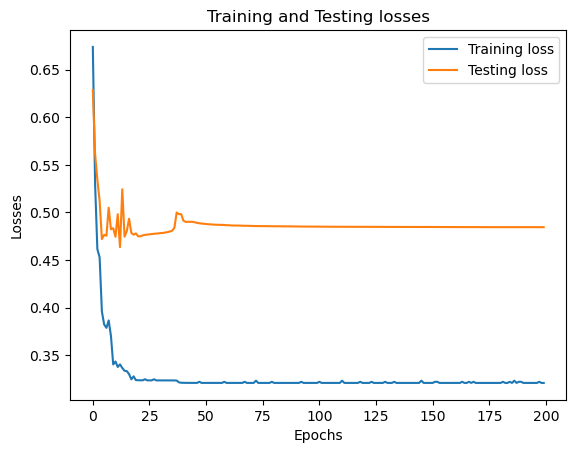

In [7]:
## INSERT CODE HERE:
plt.figure()
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training and Testing losses')
plt.legend()
plt.show()

## Task 2: Compute the minimum train and test loss achieved during training and report them

In [8]:
## INSERT CODE HERE
m_trainloss = min(train_losses)
m_testloss = min(test_losses)
print(f'Minimum train loss = {m_trainloss}\nMinimum test loss = {m_testloss}')

Minimum train loss = 0.3210757076740265
Minimum test loss = 0.4635454515616099


## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [9]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(dropout) #1st dropout
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.dropout2 = nn.Dropout(dropout) #2nd dropout
        self.fc2 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(dropout) #3rd dropout
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # INSERT CODE BELOW

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        # INSERT CODE BELOW
        x = self.dropout1(x) #Applying 1st dropout
        x = self.fc1(x)
        x = self.dropout2(x) #Applying 2nd dropout
        x = self.fc2(x)
        x = self.dropout3(x) #Applying 3rd dropout
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [10]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6729, Test Loss: 0.6864
Epoch 2/200, Loss: 0.5930, Test Loss: 0.5953
Epoch 3/200, Loss: 0.5423, Test Loss: 0.6227
Epoch 4/200, Loss: 0.5143, Test Loss: 0.6510
Epoch 5/200, Loss: 0.4697, Test Loss: 0.5343
Epoch 6/200, Loss: 0.4437, Test Loss: 0.5184
Epoch 7/200, Loss: 0.4265, Test Loss: 0.4956
Epoch 8/200, Loss: 0.3991, Test Loss: 0.4798
Epoch 9/200, Loss: 0.3756, Test Loss: 0.5237
Epoch 10/200, Loss: 0.3991, Test Loss: 0.5220
Epoch 11/200, Loss: 0.4079, Test Loss: 0.5985
Epoch 12/200, Loss: 0.4009, Test Loss: 0.4944
Epoch 13/200, Loss: 0.3512, Test Loss: 0.4906
Epoch 14/200, Loss: 0.3451, Test Loss: 0.4520
Epoch 15/200, Loss: 0.3494, Test Loss: 0.4786
Epoch 16/200, Loss: 0.3398, Test Loss: 0.4527
Epoch 17/200, Loss: 0.3284, Test Loss: 0.4520
Epoch 18/200, Loss: 0.3472, Test Loss: 0.4390
Epoch 19/200, Loss: 0.3321, Test Loss: 0.4425
Epoch 20/200, Loss: 0.3256, Test Loss: 0.4421
Epoch 21/200, Loss: 0.3229, Test Loss: 0.4406
Epoch 22/200, Loss: 0.3231, Test Loss: 0.46

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

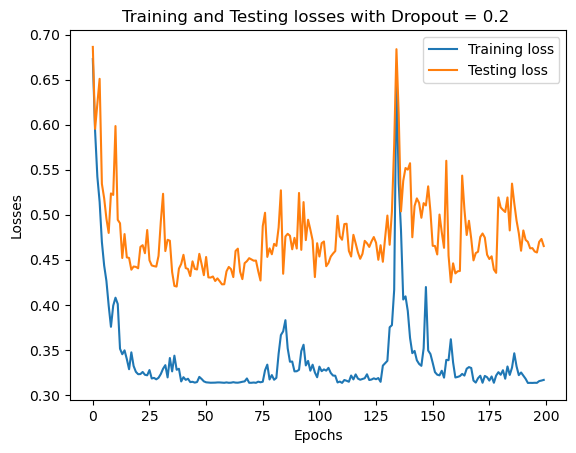

In [11]:
# INSERT CODE HERE:
plt.figure()
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training and Testing losses with Dropout = 0.2 ')
plt.legend()
plt.show()


## Task 6: Compute the minimum train and test loss achieved during training and report them

In [12]:
# INSERT CODE HERE
m_trainloss = min(train_losses)
m_testloss = min(test_losses)
print(f'Minimum train loss = {m_trainloss}\nMinimum test loss = {m_testloss}')

Minimum train loss = 0.31326183428366977
Minimum test loss = 0.4202801287174225


## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [13]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout= 0.5)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7740, Test Loss: 0.7725
Epoch 2/200, Loss: 0.7110, Test Loss: 0.6980
Epoch 3/200, Loss: 0.6409, Test Loss: 0.7040
Epoch 4/200, Loss: 0.6241, Test Loss: 0.6609
Epoch 5/200, Loss: 0.5842, Test Loss: 0.6600
Epoch 6/200, Loss: 0.5615, Test Loss: 0.6091
Epoch 7/200, Loss: 0.5374, Test Loss: 0.6340
Epoch 8/200, Loss: 0.4998, Test Loss: 0.5513
Epoch 9/200, Loss: 0.5178, Test Loss: 0.5532
Epoch 10/200, Loss: 0.4797, Test Loss: 0.5170
Epoch 11/200, Loss: 0.4764, Test Loss: 0.5521
Epoch 12/200, Loss: 0.4648, Test Loss: 0.5491
Epoch 13/200, Loss: 0.4469, Test Loss: 0.5168
Epoch 14/200, Loss: 0.4410, Test Loss: 0.5181
Epoch 15/200, Loss: 0.4178, Test Loss: 0.5191
Epoch 16/200, Loss: 0.4242, Test Loss: 0.5420
Epoch 17/200, Loss: 0.4266, Test Loss: 0.5126
Epoch 18/200, Loss: 0.3969, Test Loss: 0.5093
Epoch 19/200, Loss: 0.4017, Test Loss: 0.5031
Epoch 20/200, Loss: 0.3891, Test Loss: 0.5201
Epoch 21/200, Loss: 0.3877, Test Loss: 0.5008
Epoch 22/200, Loss: 0.3678, Test Loss: 0.51

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

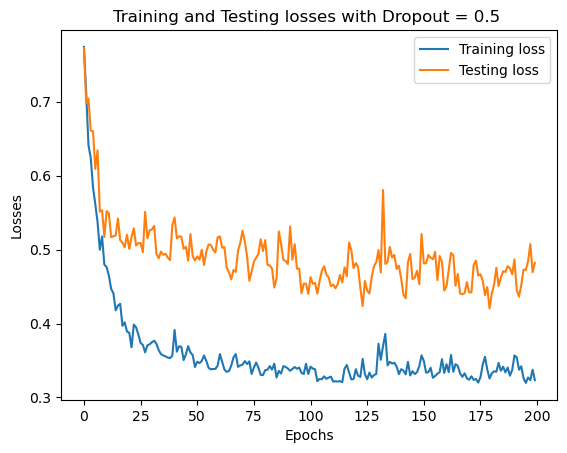

In [14]:
# INSERT CODE HERE
plt.figure()
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training and Testing losses with Dropout = 0.5 ')
plt.legend()
plt.show()

## Task 9: Compute the minimum train and test loss achieved during training and report them

In [15]:
# INSERT CODE HERE
m_trainloss = min(train_losses)
m_testloss = min(test_losses)
print(f'Minimum train loss = {m_trainloss}\nMinimum test loss = {m_testloss}')

Minimum train loss = 0.31970958908398944
Minimum test loss = 0.42036473751068115


## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

Epoch 1/200, Loss: 0.7253, Test Loss: 0.6806
Epoch 2/200, Loss: 0.7387, Test Loss: 0.6721
Epoch 3/200, Loss: 0.7329, Test Loss: 0.6709
Epoch 4/200, Loss: 0.7101, Test Loss: 0.6936
Epoch 5/200, Loss: 0.7117, Test Loss: 0.6927
Epoch 6/200, Loss: 0.7118, Test Loss: 0.6812
Epoch 7/200, Loss: 0.6858, Test Loss: 0.6729
Epoch 8/200, Loss: 0.6716, Test Loss: 0.6740
Epoch 9/200, Loss: 0.6733, Test Loss: 0.6711
Epoch 10/200, Loss: 0.6620, Test Loss: 0.6565
Epoch 11/200, Loss: 0.6531, Test Loss: 0.6648
Epoch 12/200, Loss: 0.6417, Test Loss: 0.6386
Epoch 13/200, Loss: 0.6416, Test Loss: 0.6363
Epoch 14/200, Loss: 0.6250, Test Loss: 0.6585
Epoch 15/200, Loss: 0.5839, Test Loss: 0.6313
Epoch 16/200, Loss: 0.5882, Test Loss: 0.6280
Epoch 17/200, Loss: 0.5599, Test Loss: 0.6148
Epoch 18/200, Loss: 0.5772, Test Loss: 0.6297
Epoch 19/200, Loss: 0.5511, Test Loss: 0.6391
Epoch 20/200, Loss: 0.5677, Test Loss: 0.6131
Epoch 21/200, Loss: 0.5445, Test Loss: 0.5804
Epoch 22/200, Loss: 0.5231, Test Loss: 0.56

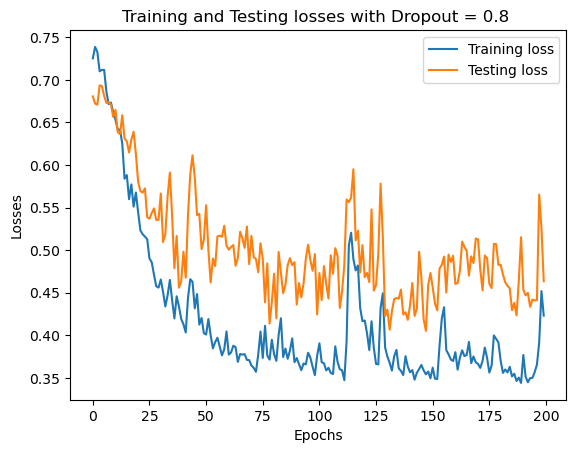

Minimum train loss = 0.3440502534310023
Minimum test loss = 0.4052012860774994


In [16]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout= 0.8)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

#Plotting loss v epoch for dropout 0.8
plt.figure()
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training and Testing losses with Dropout = 0.8 ')
plt.legend()
plt.show()

#Minimum test train losses
m_trainloss = min(train_losses)
m_testloss = min(test_losses)
print(f'Minimum train loss = {m_trainloss}\nMinimum test loss = {m_testloss}')


## Observations:
As the dropout increases, the test loss decreases. The training loss decreases at 0.2 but then increases as
the dropout increases. This means there is a trade off between train and test loss as dropout increases, and to 
balance improving generalization and underutilizing the models capacity, or training performance, due to excessive dropout. 